In [1]:
%%capture

from cycler import cycler
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from palettable.cartocolors.sequential import agSunset_7_r
from palettable.cartocolors.qualitative import Bold_7
import pandas
import scipy.stats
import textwrap

from data.process import combined, map_filter_na_inplace

CMAP_SEQUENTIAL = agSunset_7_r.mpl_colormap
CMAP_QUALITATIVE = Bold_7.mpl_colormap

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Noto Sans'
plt.rcParams['axes.edgecolor'] = 'none'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['grid.color'] = 'lightgrey'

df = combined()
df['source'] = df.form.apply(
    lambda cell: 'Online' if cell == 'English Online' else 'In Person',
).astype('category')

# Report on Community Engagement

Municipal Broadband PDX, an advocacy campaign supporting digital equity in the Portland metropolitan area, is pleased to have the opportunity to research and report on local residents' engagement with the proposed publicly-owned network in Multnomah County.

(TODO: Finish this introduction.)

## Survey Findings


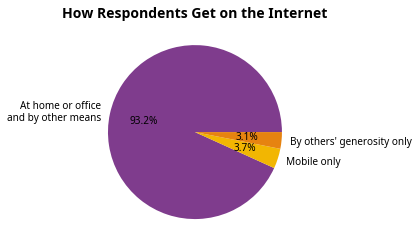

In [2]:
df.filter(['has_internet_premise', 'has_internet_mobile_only', 'has_internet_ext_only']).agg('sum').rename({
    'has_internet_premise': textwrap.fill('At home or office and by other means', 20),
    'has_internet_mobile_only': 'Mobile only',
    'has_internet_ext_only': "By others' generosity only",
}).plot(
    kind='pie',
    autopct='%.1f%%',
    title='How Respondents Get on the Internet',
    cmap=CMAP_QUALITATIVE,
)
plt.ylabel(None)

plt.show()

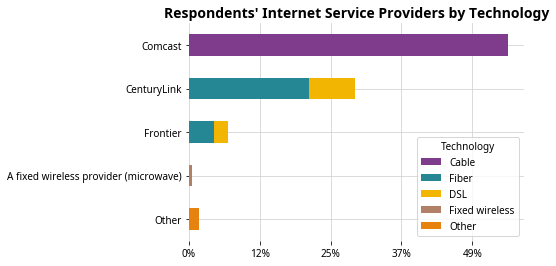

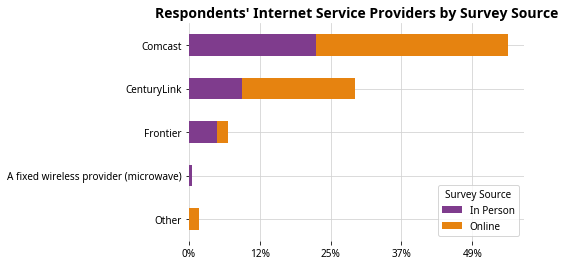

In [3]:
for col, label in {'isp_tech': 'Technology', 'source': 'Survey Source'}.items():
    isps = df.pivot_table(
        index=df.isp.cat.remove_unused_categories(),
        columns=df[col].cat.remove_unused_categories(), 
        aggfunc='size',
    )

    ax = isps.plot(kind='barh', stacked=True, cmap=CMAP_QUALITATIVE)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=df.has_internet_premise.count()))
    ax.legend(fancybox=True, title=label)
    ax.set_ylabel(None)
    ax.invert_yaxis()

    plt.title("Respondents' Internet Service Providers by {0}".format(label))

    plt.show()

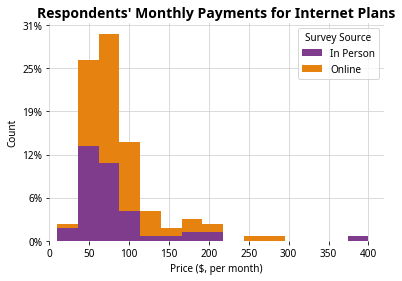

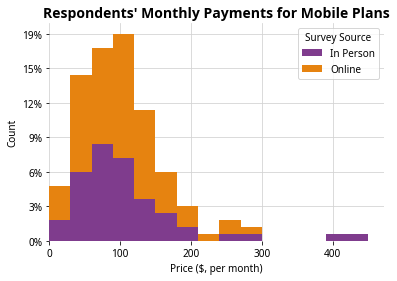

In [5]:
for col, label in {'internet_price': 'Internet', 'mobile_price': 'Mobile'}.items():
    df_pivot = df.filter(['source', col]).pivot(columns='source')
    df_pivot.columns = df_pivot.columns.droplevel()

    ax = df_pivot.plot(kind='hist', stacked=True, bins=15, cmap=CMAP_QUALITATIVE)
    ax.legend(fancybox=True, title='Survey Source')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

    plt.title("Respondents' Monthly Payments for {0} Plans".format(label))
    plt.xlabel('Price ($, per month)')
    plt.ylabel('Count')
    plt.xlim(left=0)

    plt.show()

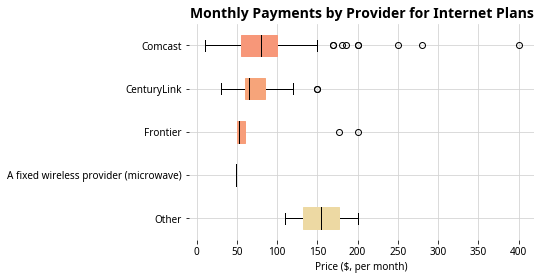

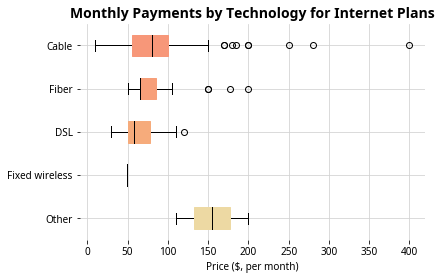

In [4]:
rcmap = cm.ScalarMappable(
    norm=colors.Normalize(vmin=0, vmax=df['internet_price'].max(), clip=True),
    cmap=CMAP_SEQUENTIAL,
)

for group, label in {'isp': 'Provider', 'isp_tech': 'Technology'}.items():
    r = df.boxplot(
        by=df[group].cat.remove_unused_categories(),
        column='internet_price',
        vert=False,
        return_type='both',
        patch_artist=True,
    )

    # Color fixes
    mean = df.groupby(group).mean()['internet_price']
    for patch, color in zip(r.internet_price.lines['boxes'], rcmap.to_rgba(mean)):
        patch.set_edgecolor(color)
        patch.set_facecolor(color)

    for k in ['medians', 'whiskers']:
        for line in r.internet_price.lines[k]:
            line.set_color('black')

    r.internet_price.ax.invert_yaxis()

    plt.title('Monthly Payments by {0} for Internet Plans'.format(label))
    plt.suptitle(None)
    plt.xlabel('Price ($, per month)')

    plt.show()

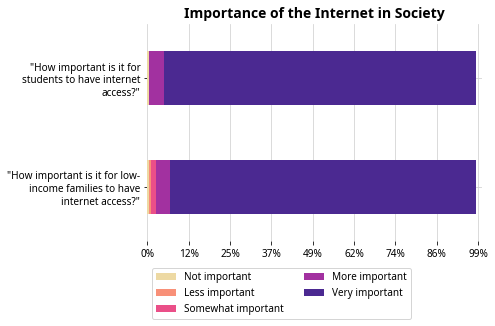

In [6]:
s = df.filter(['importance_student', 'importance_low_income']).stack()
idf = pandas.DataFrame(s.groupby([pandas.Grouper(level=1), s]).size()).unstack()
idf.columns = idf.columns.droplevel()
idf.rename(index={
    'importance_student': textwrap.fill('"How important is it for students to have internet access?"', 30),
    'importance_low_income': textwrap.fill('"How important is it for low-income families to have internet access?"', 30),
}, inplace=True)

ax = idf.plot(kind='barh', stacked=True, cmap=CMAP_SEQUENTIAL)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

plt.title("Importance of the Internet in Society")
plt.xlim(0, len(df.index))
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=2)

plt.show()

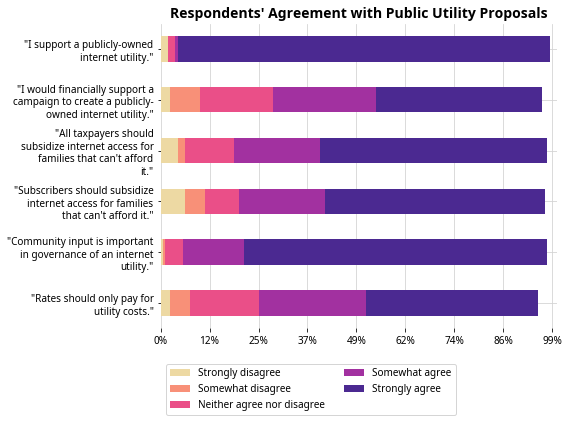

In [7]:
s = df.filter([
    'support_utility',
    'support_financial',
    'importance_user_input',
    'importance_rates_direct',
    'subsidize_subscribers',
    'subsidize_taxpayers',
]).stack()
idf = pandas.DataFrame(s.groupby([pandas.Grouper(level=1), s]).size()).unstack()
idf.columns = idf.columns.droplevel()
idf.rename(index={
    'support_utility': textwrap.fill('"I support a publicly-owned internet utility."', 30),
    'support_financial': textwrap.fill('"I would financially support a campaign to create a publicly-owned internet utility."', 30),
    'subsidize_taxpayers': textwrap.fill('"All taxpayers should subsidize internet access for families that can\'t afford it."', 30),
    'subsidize_subscribers': textwrap.fill('"Subscribers should subsidize internet access for families that can\'t afford it."', 30),
    'importance_user_input': textwrap.fill('"Community input is important in governance of an internet utility."', 30),
    'importance_rates_direct': textwrap.fill('"Rates should only pay for utility costs."', 30),
}, inplace=True)

ax = idf.plot(
    kind='barh',
    stacked=True,
    figsize=(8, 6),
    cmap=CMAP_SEQUENTIAL,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

plt.title("Respondents' Agreement with Public Utility Proposals")
plt.xlim(0, len(df.index))
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=2)
plt.tight_layout()

plt.show()

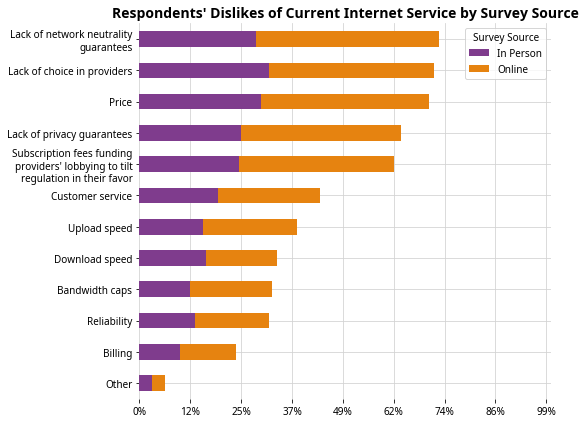

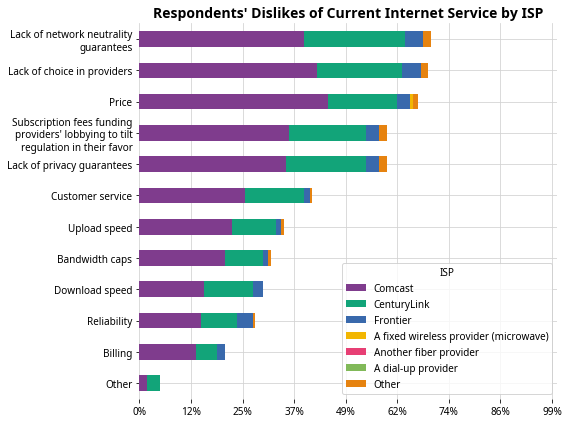

In [8]:
ddf = df.filter(['source', 'isp', 'dislikes']).explode('dislikes')
map_filter_na_inplace(
    lambda s: s.apply(lambda cell: textwrap.fill(cell, 30)),
    ddf, 'dislikes',
)

for group, label in {'source': 'Survey Source', 'isp': 'ISP'}.items():
    s = ddf.groupby([group, 'dislikes']).size()
    ddf_pivot = pandas.DataFrame(s).unstack(level=0)
    ddf_pivot.columns = ddf_pivot.columns.droplevel().astype(str)

    ddf_pivot['_Sum'] = ddf_pivot.sum(axis=1)
    ddf_pivot.sort_values('_Sum', inplace=True)
    ddf_pivot.drop(columns=['_Sum'], inplace=True)

    ax = ddf_pivot.plot(
        kind='barh',
        stacked=True,
        figsize=(8, 6),
        cmap=CMAP_QUALITATIVE,
    )
    ax.legend(fancybox=True, title=label)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

    plt.title("Respondents' Dislikes of Current Internet Service by {0}".format(label))
    plt.xlim(0, len(df.index))
    plt.ylabel(None)
    plt.tight_layout()

    plt.show()